# Figure S5: first baroclinic gravity wave speed

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_plots, exptdict, yearly_mean, shelf_mask_isobath)
import gsw

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35849/status,
Dashboard: /proxy/35849/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44217,Workers: 7
Dashboard: /proxy/35849/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:35231,Total threads: 4
Dashboard: /proxy/45001/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:40237,


## Load data

In [4]:
def f(lat):
    '''Coriolis parameter'''
    return 2*(2*np.pi/(60*60*24))*np.sin(lat*np.pi/180) # 1/s

In [5]:
%%time
ekey = 'ctrl'
start_time = '2150-01-01'
end_time = '2159-12-31'

e = exptdict[ekey]
session = cc.database.create_session()

ht = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'ht',
    session=cc.database.create_session(), n=1).sel(
    yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85))
ht_shelf, shelf_mask = shelf_mask_isobath(ht, output_mask=True)
land_mask = (ht*0).fillna(1)

dxt = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'dxt', session=cc.database.create_session(),
    n=1, ncfile='ocean_grid.nc',
    chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'}).sel(
    yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85))

salt = yearly_mean(cc.querying.getvar(
    e['expt'], 'salt', session, frequency='1 monthly',
    start_time=start_time, end_time=end_time,
    chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
        yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85)).isel(
    time=slice(3))).mean('time')
e['salt'] = salt.where(np.isnan(ht) == False)

temp = yearly_mean(cc.querying.getvar(
    e['expt'], 'temp', session,  frequency='1 monthly',
    start_time=start_time, end_time=end_time,
    chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
        yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85)).isel(
    time=slice(3))).mean('time') - 273.15
e['temp'] = temp.where(np.isnan(ht) == False)

# Calculation of the First baroclinic gravity wave speed based on
# N2 from T and S profiles following the code available at 
# https://ecjoliver.weebly.com/rossby-radius.html

lon = e['temp'].xt_ocean
lat = e['temp'].yt_ocean
depth = e['temp'].st_ocean

lat_3D = lat.expand_dims({"xt_ocean": len(lon)}, axis=-1).expand_dims(
    {"st_ocean": len(depth)}, axis=0)
lat_3D['xt_ocean'] = lon
lat_3D['st_ocean'] = depth

pres = gsw.p_from_z(-depth, lat)
pres_3D = pres.expand_dims({"xt_ocean": len(lon)}, axis=-1)
pres_3D['xt_ocean'] = lon

SA = gsw.SA_from_SP(e['salt'], pres, lon, lat)
CT = e['temp']
N2, p_N2 = gsw.Nsquared(SA, CT, pres_3D, lat_3D)

# Replace negative values at the shallowest depth (depth index 0) with 10e-8
N2[0, :, :] = np.where(N2[0, :, :] < 0, 10e-8, N2[0, :, :])

# Fix negative values of N2, following Chelton et al. (1998):
# Replace a negative value with the (pos) value at the next shallowest depth.
for k in range(1, N2.shape[0]):
    # Find negative values at the current depth
    neg_mask = N2[k, :, :] < 0
    
    # Replace negative values with the values from the next shallower depth
    N2[k, :, :][neg_mask] = N2[k - 1, :, :][neg_mask]

# Calculate c1, cR
N2 = np.where(np.isnan(N2), 0, N2)
# First baroclinic gravity wave speed [m/s]
c1 = -np.trapz(np.sqrt(N2), gsw.z_from_p(p_N2, lat_3D[:-1, :]), axis=0) / np.pi
c1 = np.where(np.isnan(SA[0, :]), np.nan, c1)
# Rossby radius of deformation [m]
e['cR'] = c1 / np.abs(f(lat_3D[0, :].drop('st_ocean')))
e['c1'] = 0*e['cR'] + c1 # make it a DataArray

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22610875676480 and this is thread id 22609272493824.
Exception closing connection <sqlite3.Connection object at 0x149020bbfa40>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

CPU times: user 10.8 s, sys: 2.34 s, total: 13.1 s
Wall time: 49.1 s


## Plot

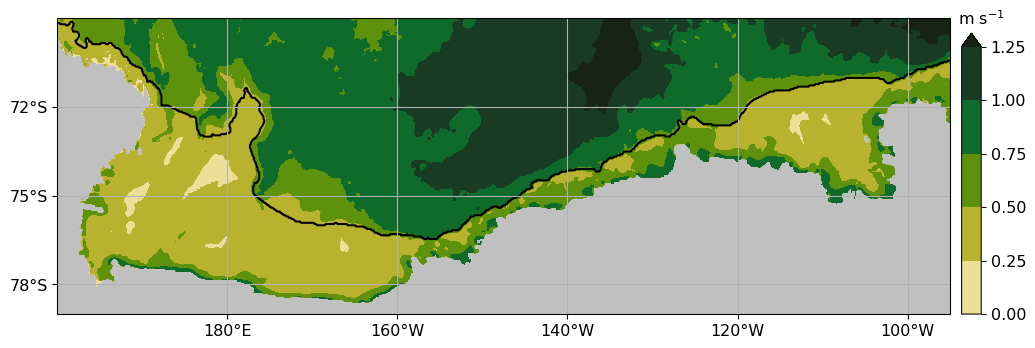

In [6]:
e = exptdict['ctrl']
    
fig, ax = plt.subplots(
        1, 1, figsize=(12, 4), subplot_kw={
            'projection': ccrs.PlateCarree(central_longitude=185)})
proj = ccrs.PlateCarree()

ax.set_extent([160, 265, -79, -69])
ax.contourf(land_mask.xt_ocean, land_mask.yt_ocean,
            land_mask, colors='silver', levels=[0.5, 2],
            zorder=2, transform=proj)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask,
            levels=[0, 1], colors = 'k',  transform=proj)
gl = ax.gridlines(draw_labels=False)
gl.xlocator = mticker.FixedLocator(
    [180, -160, -140, -120, -100])
ax.set_xticks([180, -160, -140, -120, -100], crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter(
    dateline_direction_label=True))
gl.ylocator = mticker.FixedLocator(
    np.arange(-81, -70, 3))
ax.set_yticks(np.arange(-81, -70, 3), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.ylim(-79, None)
ax.set_aspect('auto')

p = plt.contourf(e['c1'].xt_ocean, e['c1'].yt_ocean, e['c1'],
                 levels=np.arange(0, 1.5, .25), cmap='cmo.speed',
                 extend='max', transform=proj)

pos = ax.get_position()
cax = plt.axes([pos.xmax+.01, pos.ymin,
                0.017, .95*(pos.ymax-pos.ymin)])
cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='both')
cb.ax.set_title('m s$^{-1}$', x=1)

# plt.savefig(path_plots + 'FigS5.png', dpi=300, bbox_inches="tight")
plt.show()